## Segmenting and Clustering Neighbourhoods in the City of Toronto

In [23]:
# Importing required libraries

import numpy as np
import pandas as pd
import json
import requests
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

#### Reading csv file which we created from previous notebook and making a dataframe

In [2]:
df = pd.read_csv("City_of_Toronto_with_Coordinates.csv")
df.head()

,Unnamed: 0,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [3]:
# Drop unnecessary columns

df.drop(columns=['Unnamed: 0', 'PostalCode'], inplace=True)
df.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


In [4]:
# Getting total boroughs and neighbourhoods in our dataframe
print("The dataframe has {} boroughs and {} neighbourhoods" .format(len(df['Borough'].unique()), df.shape[0]))

The dataframe has 11 boroughs and 103 neighbourhoods


#### Using geopy library get the Toronto city coordinates

In [5]:
address = 'city of Toronto'
geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("The Toronto city coordinates are {},{}" .format(latitude, longitude))

The Toronto city coordinates are 43.7170226,-79.4197830350134


#### Displaying map of Toronto city with its coordinates superimposed on its top

In [6]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}' .format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(map_toronto)
        
map_toronto

#### However for illustration purpose, Let's extract boroughs with end name as Toronto and analyse that data

In [25]:
toronto_data = df[df.Borough.str.contains('Toronto')].reset_index(drop=True)
toronto_data.head()

,Borough,Neighbourhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,Central Toronto,Lawrence Park,43.728020,-79.388790


In [8]:
# Getting the boroughs in our filtered dataframe
toronto_data['Borough'].value_counts()

Downtown Toronto    18
Central Toronto      9
West Toronto         6
East Toronto         5
Name: Borough, dtype: int64

In [9]:
# Getting the shape of our dataframe
toronto_data.shape[0]

38

#### Let's create Foursquare credentials and version

In [26]:
CLIENT_ID = 'UPCBLAD5NBNFUBJPNXR3QOTOZYOULQ4Z5WAECNBYXKBEUTII' # your Foursquare ID
CLIENT_SECRET = 'DZIDELWJRPHWVDDSBBEF4COJK2JOSL503UGKCY1V2FYOEO0P' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UPCBLAD5NBNFUBJPNXR3QOTOZYOULQ4Z5WAECNBYXKBEUTII
CLIENT_SECRET:DZIDELWJRPHWVDDSBBEF4COJK2JOSL503UGKCY1V2FYOEO0P


#### Let's analyse first neighbourhood of our dataframe

In [27]:
toronto_data.loc[0, 'Neighbourhood']

'The Beaches'

In [28]:
# Getting the latitudes and longitudes of our neighbourhood

neighbourhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighbourhood_name = toronto_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


#### Now, let's get the top 100 venues that are in The Beaches within a radius of 500 meters

In [29]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,neighbourhood_latitude,neighbourhood_longitude,VERSION,radius,LIMIT)
url


'https://api.foursquare.com/v2/venues/explore?client_id=UPCBLAD5NBNFUBJPNXR3QOTOZYOULQ4Z5WAECNBYXKBEUTII&client_secret=DZIDELWJRPHWVDDSBBEF4COJK2JOSL503UGKCY1V2FYOEO0P&ll=43.67635739999999,-79.2930312&v=20180605&radius=500&limit=100'

In [30]:
# Send Get request and examine th results
import requests
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d1308f5348eba00233509b7'},
 'response': {'headerLocation': 'The Beaches',
  'headerFullLocation': 'The Beaches, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 43.680857404499996,
    'lng': -79.28682091449052},
   'sw': {'lat': 43.67185739549999, 'lng': -79.29924148550948}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd461bc77b29c74a07d9282',
       'name': 'Glen Manor Ravine',
       'location': {'address': 'Glen Manor',
        'crossStreet': 'Queen St.',
        'lat': 43.67682094413784,
        'lng': -79.29394208780985,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67682094413784,
          'lng': -79.29394208780985}],
        'distanc

In [31]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [32]:
# Now clean the json and make it into a dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
2,Grover Pub and Grub,Pub,43.679181,-79.297215
3,Glen Stewart Ravine,Other Great Outdoors,43.676300,-79.294784
4,Upper Beaches,Neighborhood,43.680563,-79.292869


In [16]:
# Total venues returned by Foursquare
nearby_venues.shape[0]

5

## Explore neighbourhoods in toronto

In [33]:
# Create a function to repeat same process to all neighbourhoods in our dataframe

def getNearbyVenues(names, borough_names, latitudes, longitudes, radius=500):
    venues_list = []
    for name, borough_name, lat, lng in zip(names, borough_names, latitudes, longitudes):
        print(name, ',', borough_name)
     # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough_name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Borough',                
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
        

In [34]:
# Calling the above function

toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   borough_names=toronto_data['Borough'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )


The Beaches , East Toronto
The Danforth West,Riverdale , East Toronto
The Beaches West,India Bazaar , East Toronto
Studio District , East Toronto
Lawrence Park , Central Toronto
Davisville North , Central Toronto
North Toronto West , Central Toronto
Davisville , Central Toronto
Moore Park,Summerhill East , Central Toronto
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West , Central Toronto
Rosedale , Downtown Toronto
Cabbagetown,St. James Town , Downtown Toronto
Church and Wellesley , Downtown Toronto
Harbourfront,Regent Park , Downtown Toronto
Ryerson,Garden District , Downtown Toronto
St. James Town , Downtown Toronto
Berczy Park , Downtown Toronto
Central Bay Street , Downtown Toronto
Adelaide,King,Richmond , Downtown Toronto
Harbourfront East,Toronto Islands,Union Station , Downtown Toronto
Design Exchange,Toronto Dominion Centre , Downtown Toronto
Commerce Court,Victoria Hotel , Downtown Toronto
Roselawn , Central Toronto
Forest Hill North,Forest Hill West , Central Tor

In [19]:
# Checking the size of resulting dataframe
print(toronto_venues.shape)
toronto_venues.head()

(1700, 8)


,Neighbourhood,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,East Toronto,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,East Toronto,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,East Toronto,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,East Toronto,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,The Beaches,East Toronto,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


#### Checking how many venues were returned for each neighbourhood

In [20]:
toronto_venues.groupby(['Borough', 'Neighbourhood']).count()

Neighbourhood Latitude  \
Borough          Neighbourhood                                                                
Central Toronto  Davisville                                                              38   
                 Davisville North                                                         9   
                 Deer Park,Forest Hill SE,Rathnelly,South Hill,S...                      14   
                 Forest Hill North,Forest Hill West                                       4   
                 Lawrence Park                                                            3   
                 Moore Park,Summerhill East                                               2   
                 North Toronto West                                                      16   
                 Roselawn                                                                 2   
                 The Annex,North Midtown,Yorkville                                       23   
Downtown Toronto Adelaide,King,Richmond                                                 100   
                 Berczy Park                                                             55   
                 CN Tower,Bathurst Quay,Island airport,Harbourfr...                      16   
                 Cabbagetown,St. James Town                                              46   
                 Central Bay Street                                                      88   
                 Chinatown,Grange Park,Kensington Market                                100   
                 Christie                                                                15   
                 Church and Wellesley                                                    87   
                 Commerce Court,Victoria Hotel                                          100   
                 Design Exchange,Toronto Dominion Centre                                100   
                 First Canadian Place,Underground city                                  100   
                 Harbord,University of Toronto                                           34   
                 Harbourfront East,Toronto Islands,Union Station                        100   
                 Harbourfront,Regent Park                                                48   
                 Rosedale                                                                 4   
                 Ryerson,Garden District                                                100   
                 St. James Town                                                         100   
                 Stn A PO Boxes 25 The Esplanade                                         94   
East Toronto     Business Reply Mail Processing Centre 969 Eastern                       19   
                 Studio District                                                         38   
                 The Beaches                                                              5   
                 The Beaches West,India Bazaar                                           18   
                 The Danforth West,Riverdale                                             42   
West Toronto     Brockton,Exhibition Place,Parkdale Village                              22   
                 Dovercourt Village,Dufferin                                             20   
                 High Park,The Junction South                                            23   
                 Little Portugal,Trinity                                                 62   
                 Parkdale,Roncesvalles                                                   15   
                 Runnymede,Swansea                                                       38   

                                                                     Neighbourhood Longitude  \
Borough          Neighbourhood                                                                 
Central Toronto  Davisville                                                 

In [21]:
# Getting unique categories of venues
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 238 uniques categories.


## Analyse each neighbourhood

In [35]:
# Onehot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighborhood and borough column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 
#toronto_onehot['Borough'] = toronto_venues['Borough']
toronto_onehot
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Let's examine new dataframe size
print(toronto_onehot.shape)

(1700, 239)


In [62]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.04,...,0.0,0.0,0.010000,0.0,0.0,0.0,0.01,0.0,0.0,0.000000
1,Berczy Park,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.018182,0.0,0.0,0.0,0.00,0.0,0.0,0.000000
2,"Brockton,Exhibition Place,Parkdale Village",0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.045455
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.052632
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0.0,0.0,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
# Getting the size of new dataframe
toronto_grouped.shape

(38, 239)

### Printing each neighbourhood along with top 5 most common venues

In [71]:
num_top_venues = 5
tmp = pd.DataFrame()
for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp1 = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    print(temp1)
    tmp = tmp.append(temp1.head(1))
    print('\n')
print(tmp) 


----Adelaide,King,Richmond----
                 venue  freq
0                 Café  0.05
1          Coffee Shop  0.05
2           Steakhouse  0.04
3  American Restaurant  0.04
4                  Bar  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2                Café  0.04
3              Bakery  0.04
4  Seafood Restaurant  0.04


----Brockton,Exhibition Place,Parkdale Village----
            venue  freq
0  Breakfast Spot  0.09
1     Coffee Shop  0.09
2            Café  0.09
3   Grocery Store  0.05
4       Pet Store  0.05


----Business Reply Mail Processing Centre 969 Eastern----
         venue  freq
0  Yoga Studio  0.05
1   Restaurant  0.05
2      Brewery  0.05
3      Butcher  0.05
4   Smoke Shop  0.05


----CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara----
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2  Airport Terminal  0.12
3     B

In [67]:
tmp = tmp.set_index('venue')

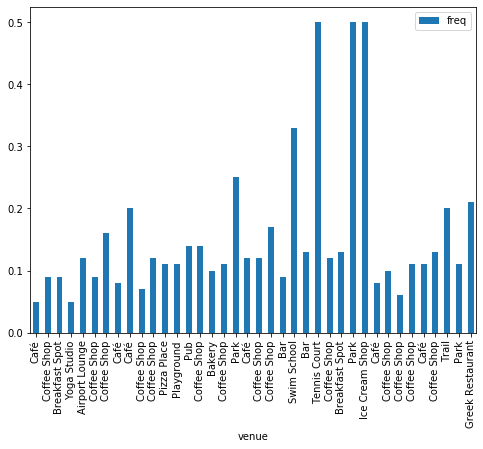

In [70]:
tmp.plot(kind='bar', figsize=(8,6))

plt.show()

In [38]:
# write a function to sort venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Let's put into dataframe

In [39]:
# Now let's create the new dataframe and display the top 5 venues for each neighborhood

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']
#neighbourhoods_venues_sorted['Borough'] = toronto_grouped['Borough']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Steakhouse,Bar,American Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Bakery,Café
2,"Brockton,Exhibition Place,Parkdale Village",Breakfast Spot,Café,Coffee Shop,Yoga Studio,Intersection
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Comic Shop,Pizza Place,Recording Studio
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Terminal,Airport Lounge,Airport Service,Boutique,Coffee Shop


## Cluster Neighbourhoods

In [40]:
# set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop(columns=['Neighbourhood'])

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30]

array([0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       4, 0, 1, 0, 0, 2, 3, 0])

In [41]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#neighbourhoods_venues_sorted.head()
toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on=['Neighbourhood'])

toronto_merged.head() # check the last columns!

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Pub,Trail,Neighborhood,Other Great Outdoors
1,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store
2,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,0,Park,Gym,Italian Restaurant,Pizza Place,Pub
3,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery
4,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Park,Swim School,Bus Line,Yoga Studio,Doner Restaurant


#### Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, pos, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(pos) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Let's visualize resulting clusters

## Examine clusters

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,The Beaches,Health Food Store,Pub,Trail,Neighborhood,Other Great Outdoors
1,"The Danforth West,Riverdale",Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store
2,"The Beaches West,India Bazaar",Park,Gym,Italian Restaurant,Pizza Place,Pub
3,Studio District,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery
5,Davisville North,Playground,Hotel,Clothing Store,Food & Drink Shop,Grocery Store
6,North Toronto West,Coffee Shop,Yoga Studio,Bagel Shop,Park,Clothing Store
7,Davisville,Pizza Place,Dessert Shop,Sandwich Place,Italian Restaurant,Café
9,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",Pub,Coffee Shop,Liquor Store,Light Rail Station,Sushi Restaurant
11,"Cabbagetown,St. James Town",Coffee Shop,Restaurant,Park,Café,Italian Restaurant
12,Church and Wellesley,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Restaurant,Gay Bar


In [42]:
import matplotlib.pyplot as plt
toronto1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
toronto1.plot(kind='bar', figsize=(10,6))
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Rosedale,Park,Playground,Trail,Dog Run,Fish & Chips Shop
23,"Forest Hill North,Forest Hill West",Jewelry Store,Trail,Park,Sushi Restaurant,Donut Shop


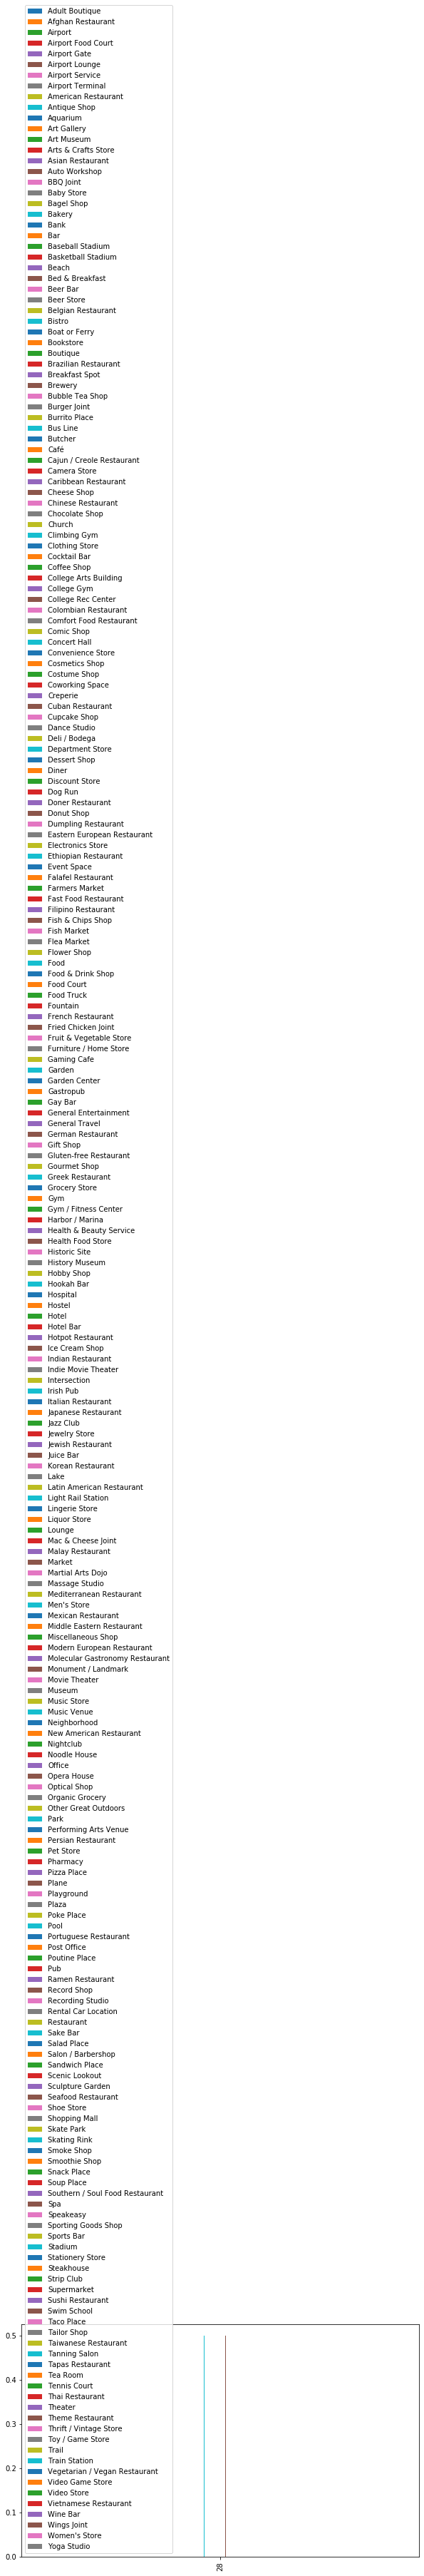

In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
toronto3 = toronto_grouped[toronto_grouped.Neighbourhood == 'Roselawn']
toronto3.plot(kind='bar', figsize=(10,6))
plt.show()

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Doner Restaurant


In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
27,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Terminal,Airport Lounge,Airport Service,Boutique,Coffee Shop
